In [1]:
import torch
from models.ccvae.models.ccvae_pl import CCVAE_L
from fomo.dataset import MultiModalDatasets
from torch.utils.data import DataLoader
from lightning.pytorch import Trainer
import numpy as np

import matplotlib.pyplot as plt
from torchmetrics.classification import ConfusionMatrix
import matplotlib.gridspec as gridspec

/home/anand/.conda/envs/TORCH21/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [2]:
def brier_score(y_true, y_pred):
    return torch.square(y_true-y_pred).mean()

In [2]:
data = MultiModalDatasets('/data/compoundx/anand/benchmark-dataset/', split_type = "test", xs_list = ["age","laicum"], target="ALL", classify=False)
data = DataLoader(data, batch_size=1000)

/gpfs1/schlecker/home/anand/Projects/FOMO-VAEM/fomo/io.py:6: RuntimeWarning: invalid value encountered in divide
  arr = (arr - mean)/std


In [4]:
y_list = []
for x, y in data:
    break

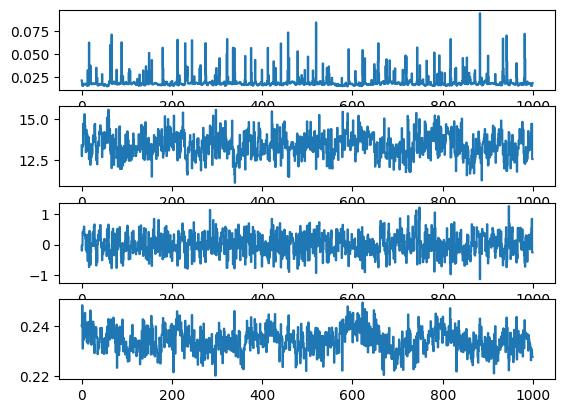

In [5]:
fig, ax = plt.subplots(4,1)
ax[0].step(np.arange(1000),y[:,0])
ax[1].step(np.arange(1000),y[:,1])
ax[2].step(np.arange(1000),y[:,2])
ax[3].step(np.arange(1000),y[:,3])
plt.show()


In [6]:
print(x[3].shape)

torch.Size([1000, 101, 1])


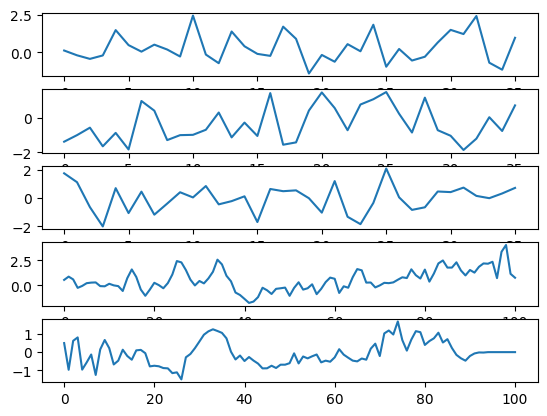

In [7]:
fig, ax = plt.subplots(5,1)
ax[0].plot(x[0][0])
ax[1].plot(x[1][0])
ax[2].plot(x[2][0])
ax[3].plot(x[3][0])
ax[4].plot(x[4][0])


In [3]:
test_data = MultiModalDatasets('/data/compoundx/anand/benchmark-dataset/', split_type = "test", xs_list = ["age","laicum"], target="ALL", classify=True)

/gpfs1/schlecker/home/anand/Projects/FOMO-VAEM/fomo/io.py:6: RuntimeWarning: invalid value encountered in divide
  arr = (arr - mean)/std


In [4]:
model_path = "/data/compoundx/anand/fomo-vaem/ccvae/lightning_logs/version_1/checkpoints/epoch=43-step=44000.ckpt"

in_shape = (1, sum(test_data.get_seq_len()))
num_classes = test_data.get_lbl_info()[1]

ccvae = CCVAE_L.load_from_checkpoint(model_path, z_dim=64,
                   num_classes=num_classes,
                   in_shape=in_shape,
                   lr = 1e-4,
                   prior_fn=lambda:torch.ones(1, num_classes) / 2,
                   test_dataset = test_data)

In [5]:
x, y, r, loc, scale = ccvae.prediction(dataset=test_data)

In [6]:
corr_mat = np.corrcoef(loc.detach().numpy().T)

(array([[ 0.,  0.,  1.,  1., 24., 35.,  2.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  1., 23., 38.,  0.,  1.,  0.,  1.],
        [ 0.,  0.,  1.,  1., 36., 24.,  0.,  1.,  0.,  1.],
        [ 0.,  0.,  0.,  2., 36., 23.,  2.,  0.,  0.,  1.],
        [26.,  1.,  1.,  4.,  7.,  3.,  1.,  0.,  4., 17.],
        [ 0., 24.,  4.,  3.,  6.,  5.,  1.,  6., 14.,  1.],
        [ 0.,  0.,  0.,  0., 34., 29.,  0.,  0.,  0.,  1.],
        [17.,  3.,  1.,  2.,  5.,  3.,  5.,  1.,  1., 26.],
        [ 0.,  0.,  0., 18., 10.,  9., 22.,  3.,  1.,  1.],
        [18.,  3.,  0.,  1.,  4.,  6.,  4.,  1.,  1., 26.],
        [17.,  3.,  1.,  2.,  4.,  4.,  5.,  1.,  2., 25.],
        [13.,  6.,  3.,  1.,  4.,  7.,  1.,  2., 17., 10.],
        [17.,  3.,  1.,  2.,  4.,  4.,  5.,  1.,  2., 25.],
        [ 0.,  0.,  1., 15., 13., 11., 23.,  0.,  0.,  1.],
        [17.,  3.,  1.,  1.,  6.,  3.,  4.,  2.,  2., 25.],
        [ 0.,  0.,  2., 12., 27., 18.,  3.,  1.,  0.,  1.],
        [27.,  0.,  1.,  4.,  6.,  4.,  

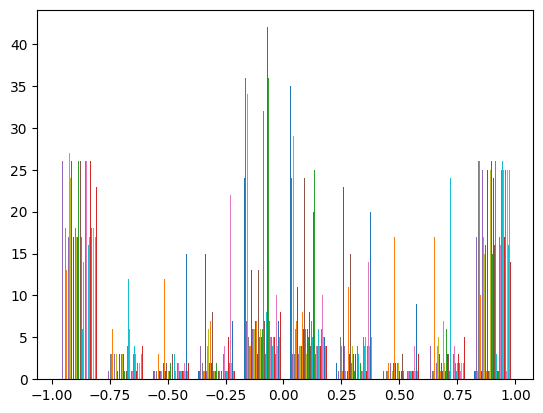

In [7]:
plt.hist(corr_mat)

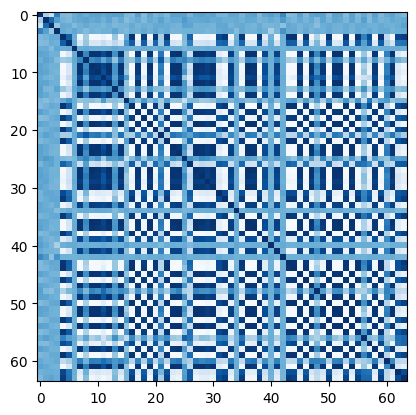

In [8]:
plt.imshow(corr_mat, cmap = "Blues")

In [9]:
y_true, y_pred = ccvae.label_prediction(prob=True)

In [10]:
r.shape

torch.Size([15994, 1, 310])

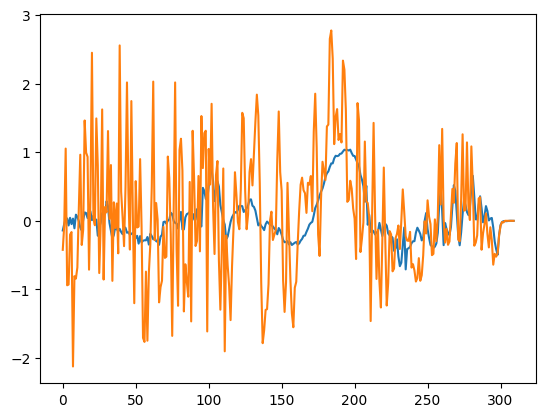

In [11]:
fig, ax = plt.subplots(1,1)
index = 150
ax.plot(r[index, 0, :].detach().numpy())
ax.plot(x[index, 0, :].detach().numpy())


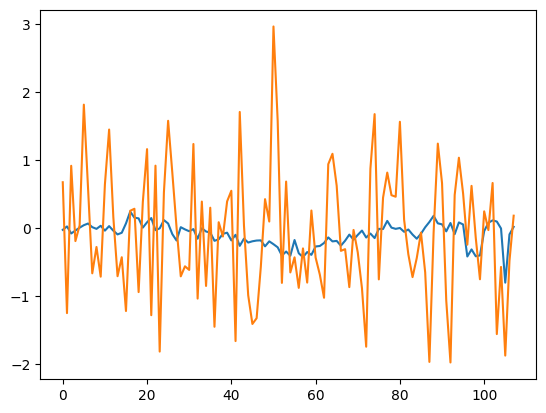

In [12]:
fig, ax = plt.subplots(1,1)

index = 100
ax.plot(r[index, 0, :108].detach().numpy())
ax.plot(x[index, 0, :108].detach().numpy())


CSI: 0.45942163467407227
Brier-Score: 0.07246467471122742


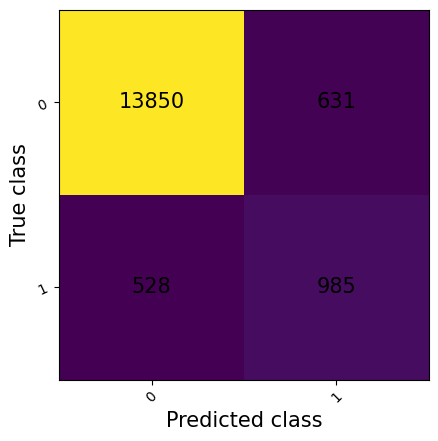

In [13]:
metric = ConfusionMatrix(task="binary", num_classes=2)
index = 0
m = metric(y_true[:,index],y_pred[:,index])
print(f"CSI: {m[1][1]/(m[1][1]+m[1][0]+m[0][1])}")
print(f"Brier-Score: {brier_score(y_true[:,index], y_pred[:,index])}")
metric.plot()
plt.show()

In [14]:
imgs= ccvae.latent_walk(torch.zeros((1,310))).detach().numpy()

/home/anand/.conda/envs/TORCH21/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


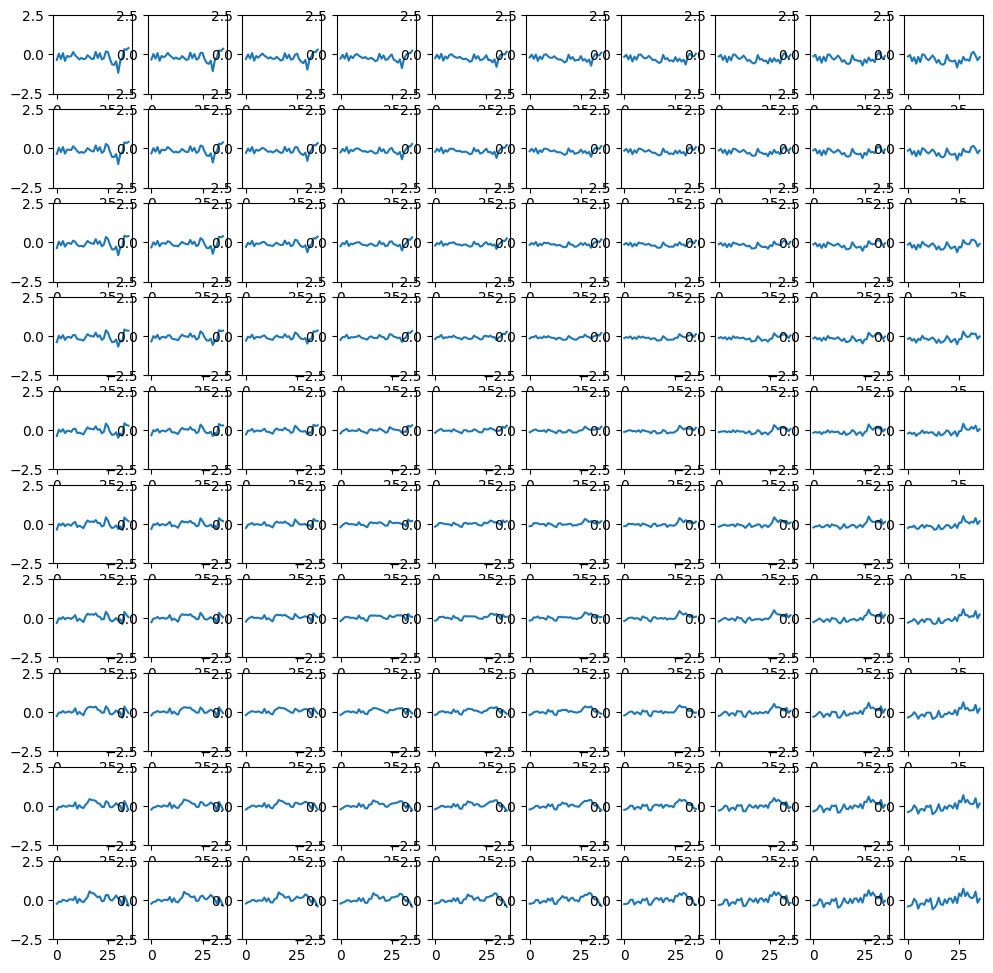

In [18]:
n_rows = 10
n_cols = 10
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig)

for i in range(100):
    ax = fig.add_subplot(gs[i])
    ax.plot(imgs[0,0,i,0,:36])
    ax.set_ylim(-2.5,2.5)

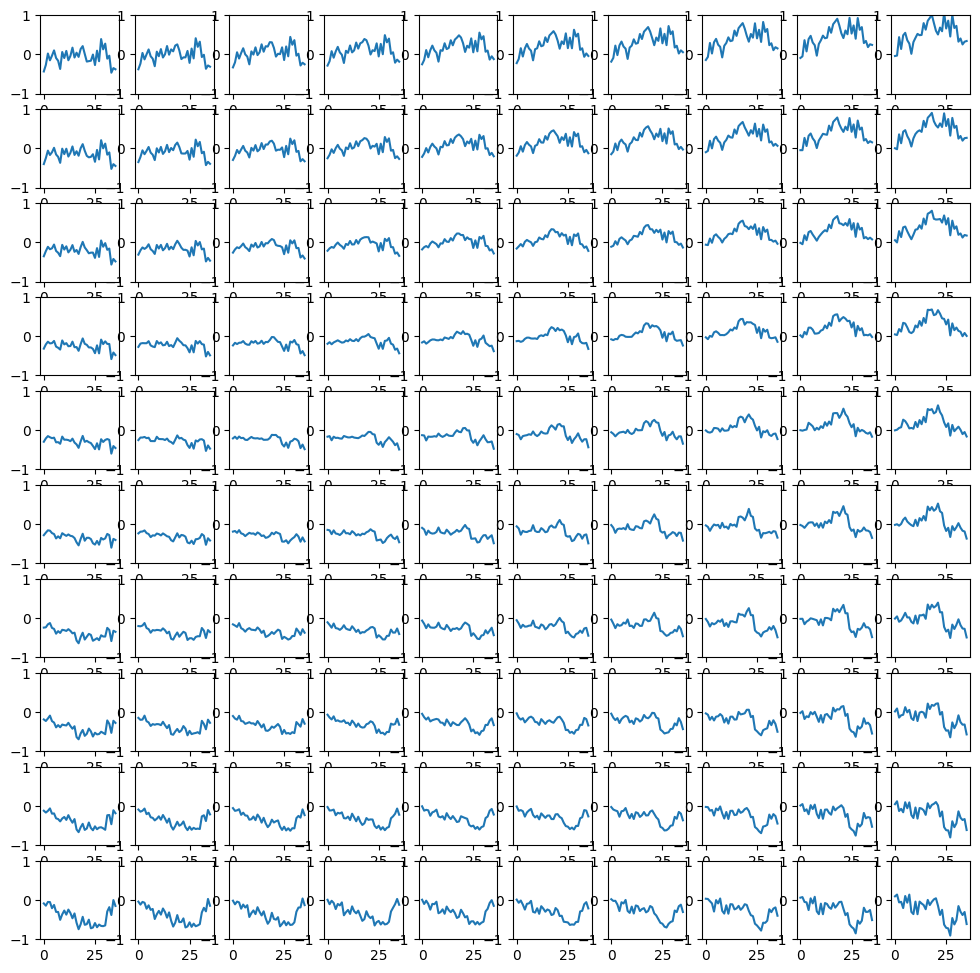

In [20]:
n_rows = 10
n_cols = 10
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig)
lim = 1
for i in range(100):
    ax = fig.add_subplot(gs[i])
    ax.plot(imgs[0,0,i,0,36:72])
    ax.set_ylim(-lim,lim)

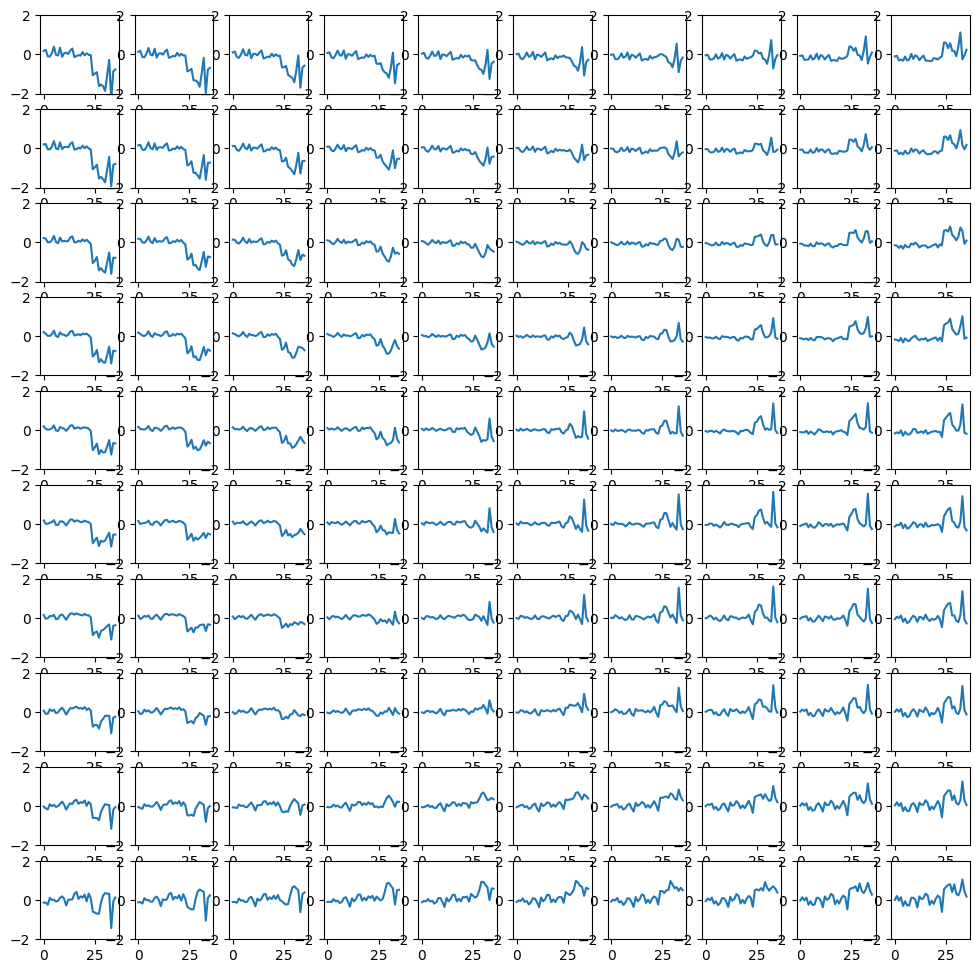

In [22]:
n_rows = 10
n_cols = 10
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig)
lim = 2
for i in range(100):
    ax = fig.add_subplot(gs[i])
    ax.plot(imgs[0,0,i,0,72:108])
    ax.set_ylim(-lim,lim)

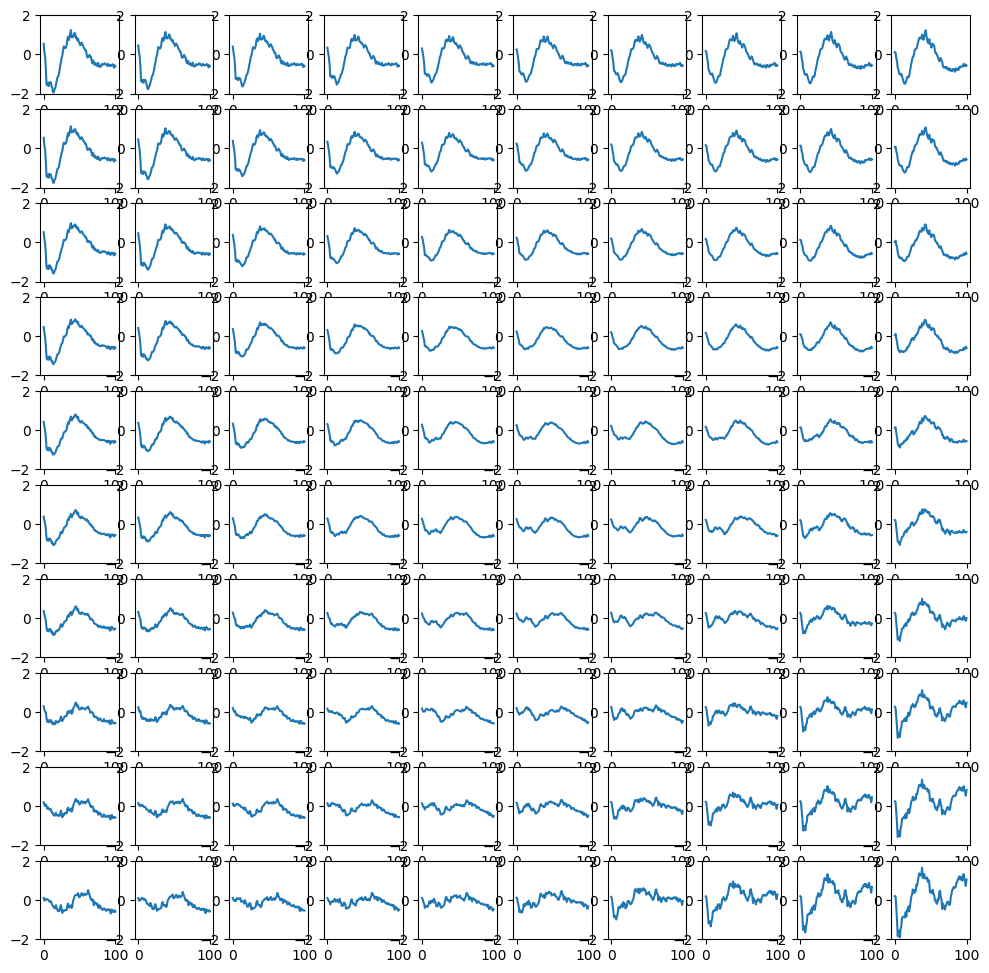

In [23]:
n_rows = 10
n_cols = 10
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig)
lim = 2
for i in range(100):
    ax = fig.add_subplot(gs[i])
    ax.plot(imgs[0,0,i,0,108:108+101])
    ax.set_ylim(-lim,lim)

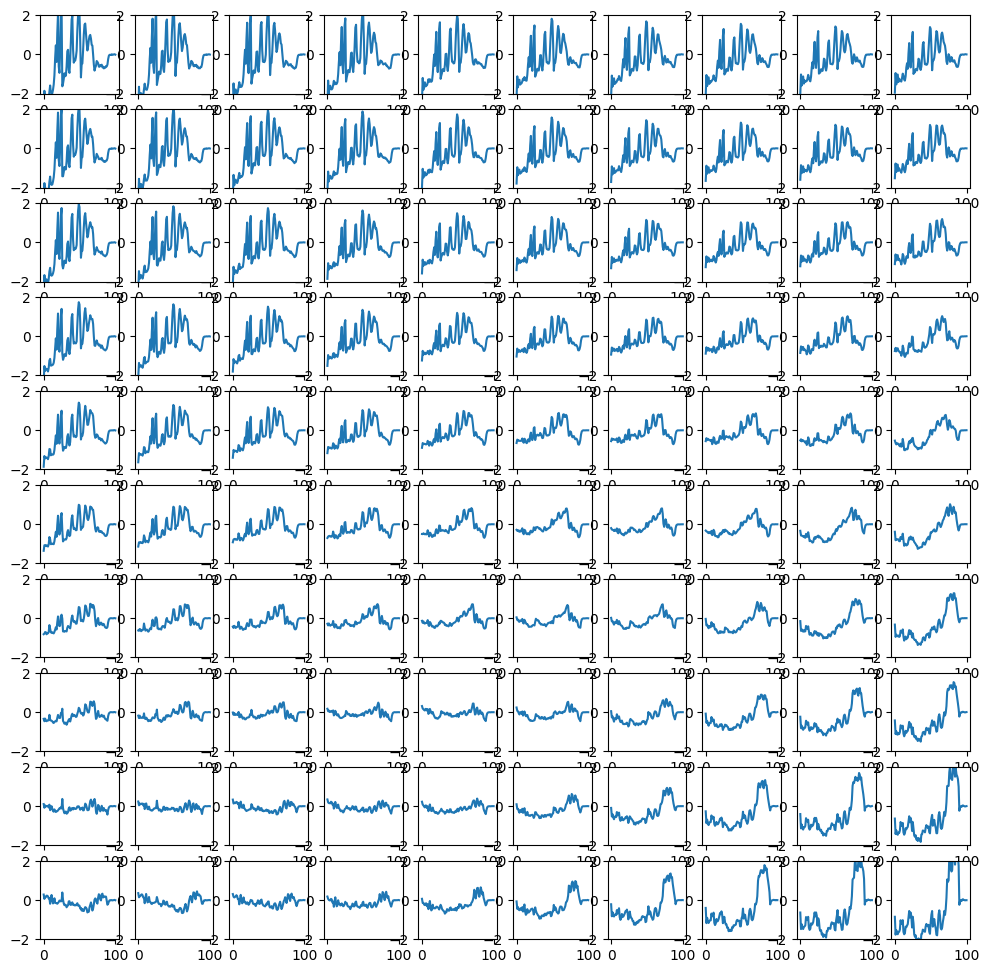

In [24]:
n_rows = 10
n_cols = 10
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig)
lim = 2
for i in range(100):
    ax = fig.add_subplot(gs[i])
    ax.plot(imgs[0,0,i,0,209:310])
    ax.set_ylim(-lim,lim)